In [ ]:
!pip install -r requirements.txt

In [1]:
PROJECT = 'ex-vivo-confocal'
BUCKET = 'ex-vivo-confocal'
REGION = 'europe-west1'

YES_FOLDER = 'gs://{}/datalake/STUDY_2021/HE/YES'.format(BUCKET)
NO_FOLDER = 'gs://{}/datalake/STUDY_2021/HE/NO'.format(BUCKET)
STAGING_FOLDER = 'gs://{}/staging/STUDY_2021/HE'.format(BUCKET)
LOCAL_STAGING_FOLDER = 'staging/he'

In [2]:
import os

os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION

os.environ['YES_FOLDER'] = YES_FOLDER
os.environ['NO_FOLDER'] = NO_FOLDER

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'credentials/key.json'

In [3]:
!gcloud auth activate-service-account \
    ml-service@ex-vivo-confocal.iam.gserviceaccount.com \
    --key-file=${GOOGLE_APPLICATION_CREDENTIALS} \
    --project=${PROJECT}

Activated service account credentials for: [ml-service@ex-vivo-confocal.iam.gserviceaccount.com]


---

In [4]:
def save_dataset(df, path, header=True):
    df_dir = os.path.dirname(path)
    df_file = os.path.basename(path)
    if os.path.exists(path):
        os.remove(path)
    if df_dir and not os.path.isdir(df_dir):
        os.makedirs(df_dir, exist_ok=True)
    df.to_csv(path, index=False, header=header)
    print("Dataframe saved into", path)

In [5]:
import pandas as pd

def createDataFrame(yes_paths, no_paths):
    """
    A label equals to 1 means 'yes' it's cancer.
    A label equals to 0 means 'no' it's cancer.
    """
    yes_df = pd.DataFrame(yes_paths, columns = ['image'])
    no_df = pd.DataFrame(no_paths, columns = ['image'])
    yes_df['label'] = 'yes'
    no_df['label'] = 'no'
    return pd.concat([yes_df, no_df], ignore_index=True)

---

## Preparing the dataset

As the original names contain spaces and other special characters, we're going to rename them.

In [ ]:
%%bash

gsutil ls gs://ex-vivo-confocal/datalake/STUDY_2021/HE/**/*.* | \
  while read f; do
    gsutil -m mv "$f" "${f// /_}";
  done;

In [6]:
# DecompressionBombError: Image size (204871680 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack. [while running 'Synthesise samples']

yes_paths = !gsutil ls -l ${YES_FOLDER}/*.* | awk '{if ($1 < 157286400) print $NF}'
no_paths = !gsutil ls -l ${NO_FOLDER}/*.* | awk '{if ($1 < 157286400) print $NF}'

In [7]:
df = createDataFrame(yes_paths, no_paths)
df.sample(5)

,image,label
225,gs://ex-vivo-confocal/datalake/STUDY_2021/HE/N...,no
458,gs://ex-vivo-confocal/datalake/STUDY_2021/HE/N...,no
142,gs://ex-vivo-confocal/datalake/STUDY_2021/HE/Y...,yes
263,gs://ex-vivo-confocal/datalake/STUDY_2021/HE/N...,no
449,gs://ex-vivo-confocal/datalake/STUDY_2021/HE/N...,no


In [8]:
yes_paths[:5]

['gs://ex-vivo-confocal/datalake/STUDY_2021/HE/YES/2x.tif',
 'gs://ex-vivo-confocal/datalake/STUDY_2021/HE/YES/2x2.tif',
 'gs://ex-vivo-confocal/datalake/STUDY_2021/HE/YES/4x.tif',
 'gs://ex-vivo-confocal/datalake/STUDY_2021/HE/YES/4x1.tif',
 'gs://ex-vivo-confocal/datalake/STUDY_2021/HE/YES/4x2.tif']

In [9]:
NUM_SAMPLES_YES = len(yes_paths)
NUM_SAMPLES_NO = len(no_paths)

print('Number of positive cases:', NUM_SAMPLES_YES)
print('Number of negative cases:', NUM_SAMPLES_NO)

Number of positive cases: 170
Number of negative cases: 346


In [10]:
path = '{}/images.csv'.format(LOCAL_STAGING_FOLDER)
# reorganise the columns to fit with the method signature
save_dataset(df[['label', 'image']], path, header=False)

Dataframe saved into staging/he/images.csv


---

In [11]:
import gcsfs
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

def load_image(path):
    """
    Loads an image from both, local filesystem or Google Storage, as Numpy array.
    
    Arguments:
      path -- path to image dataset folder.
        
    Returns:
      img -- a Numpy array with shape (hight, width, num_channels). In the RGB case
             num_channels is equal to 3.
    """
    if path.startswith('gs://'):
        fs = gcsfs.GCSFileSystem(project=BUCKET)
        img = Image.open(fs.open(path, 'rb'))
    else:
        img = Image.open(path)
    return np.asarray(img)

gs://ex-vivo-confocal/datalake/STUDY_2021/HE/YES/2x2.tif


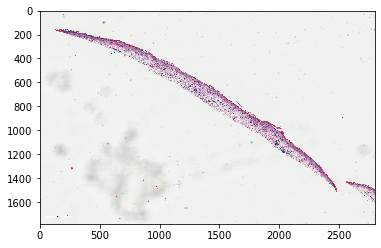

In [12]:
path = df['image'].iloc[1]
img = load_image(path)

print(path)
plt.imshow(img)
plt.show()

The images need to be resize to have all of them the same dimensions

In [13]:
IMAGE_SIZE = 300

In [14]:
import apache_beam as beam

def resize_samples(input_data, output_folder,
                       save_format='jpeg',
                       target_size=(256, 256),
                       job_mame='resize_samples',
                       runner='DirectRunner'):
    """
    Create an Apache Beam pipeline to create synthetic copies of pitcture appliying some transformations.
    
    Arguments:
    runner -- two possible values are accepted:
        DirectRunner -- executes the pipeline in the same machine that is running this method. Defaul.
        DataflowRunner -- executes the pipeline on GCP (Google Cloud Platform) using the Dataflow service.
    input_data -- path to a CSV file with the following structure:
        label,path_to_image_file,path_to_copy_file
    output -- path to the output folder
    """
    # Dataflow needs the imports here
    import os, datetime, random, string
    import numpy as np
    
    from PIL import Image
    from io import BytesIO
    from apache_beam.io.gcp import gcsio
    #from skimage.transform import resize
    from keras.preprocessing.image import ImageDataGenerator
    
    def load_img(path):
        if path.startswith('gs://'):
            #print(path)
            img = Image.open(gcsio.GcsIO().open(path))
        else:
            img = Image.open(path)
        return img
        
    def resize(element):
        label, path = element
        img = load_img(path)
        img = img.resize(target_size, Image.NEAREST)
        img = np.asarray(img)
        save_to_dir = os.path.join(
                output_folder, label.upper().replace(' ', '_'))
        return (save_to_dir, img)
            
    class WriteImage(beam.DoFn):
        def __init__(self, filesystems):
            self.filesystems = filesystems
            
        def process(self, image_tuple):
            directory, img = image_tuple
            filename = ''.join(random.choices(string.ascii_letters + string.digits, k=16))
            filename = '{}.{}'.format(filename, save_format)
            path = os.path.join(directory, filename)
            file = BytesIO()
            if save_format == 'jpeg':
                img = Image.fromarray((img * 255).astype(np.uint8)).convert('RGB')
            else:
                img = Image.fromarray((img * 255).astype(np.uint8))
            img.save(file, format=save_format)
            if not os.path.isdir(directory):
                self.filesystems.FileSystems.mkdirs(directory)
            writer = self.filesystems.FileSystems.create(path)
            writer.write(file.getvalue())
            writer.close()
            
    timestamp = datetime.datetime.now().strftime("%y%m%d-%H%M%S")

    #dictionary of pipeline options
    opts = {
        "staging_location": STAGING_FOLDER,
        "temp_location": "gs://{}/temp".format(BUCKET),
        "job_name": "{}-{}".format(job_mame, timestamp),
        "project": PROJECT,
        "region": REGION,
        "max_num_workers": 8,
        "runner": runner
    }

    #instantiate PipelineOptions object using options dictionary
    options = beam.pipeline.PipelineOptions(flags = [], **opts)
    p = beam.Pipeline(options=options)
    
    (p | 'Read dataset'   >> beam.io.ReadFromText(input_data)
       | 'Split data'     >> beam.Map(lambda x: x.split(','))
       | 'Resize samples' >> beam.Map(resize)
       | 'Save Image'     >> beam.ParDo(WriteImage(beam.io.filesystems))
    )
    
    p.run()

In [33]:
resize_samples(
    '{}/images.csv'.format(LOCAL_STAGING_FOLDER),
    STAGING_FOLDER,
    save_format='jpeg',
    target_size=(IMAGE_SIZE, IMAGE_SIZE)
)

---

## Split the dataset in three different ones:
* training
* eval
* testing

For that it's needed to dispose to the labels:

In [15]:
yes_resized = !gsutil ls gs://ex-vivo-confocal/staging/STUDY_2021/HE/YES/*.jpeg
no_resized = !gsutil ls gs://ex-vivo-confocal/staging/STUDY_2021/HE/NO/*.jpeg
    
df = createDataFrame(yes_resized, no_resized)
df.sample(5)

,image,label
93,gs://ex-vivo-confocal/staging/STUDY_2021/HE/YE...,yes
308,gs://ex-vivo-confocal/staging/STUDY_2021/HE/NO...,no
105,gs://ex-vivo-confocal/staging/STUDY_2021/HE/YE...,yes
196,gs://ex-vivo-confocal/staging/STUDY_2021/HE/NO...,no
253,gs://ex-vivo-confocal/staging/STUDY_2021/HE/NO...,no


In [16]:
import numpy as np

def split(df, train_percentage=0.8, eval_percentage=0.1):
    def split_train_test(df, train_percentage=0.8):
        msk = np.random.rand(len(df)) < train_percentage
        train = df[msk]
        test = df[~msk]
        return train, test

    def split_train_eval_test(df, train_percentage=0.8, eval_percentage=0.1):
        eval_test_percentage = eval_percentage/(1 - train_percentage)
        train, eval_test = split_train_test(df, train_percentage)
        validate, test = split_train_test(eval_test, eval_test_percentage)
        return train, validate, test
    
    # Split the datasource by label and then by test, eval and test
    classes = [
        split_train_eval_test(x, train_percentage, eval_percentage)
        for _, x in df.groupby(['label'])
    ]
    classes = list(map(list, zip(*classes)))
    
    return [pd.concat(x) for x in classes]

In [17]:
train_df, eval_df, test_df = split(df)

print("Records in the dataframe:", len(df))
print("Number of samples in the training set:", len(train_df))
print("Number of samples in the evaluation set:", len(eval_df))
print("Number of samples in the testing set:", len(test_df))
print("Number of samples in the three sets:",
      len(train_df) + len(eval_df) + len(test_df))

Records in the dataframe: 516
Number of samples in the training set: 432
Number of samples in the evaluation set: 47
Number of samples in the testing set: 37
Number of samples in the three sets: 516


In [18]:
train_df['stage'] = 'train'
eval_df['stage'] = 'eval'
test_df['stage'] = 'test'

In [19]:
all_df = pd.concat([train_df, eval_df, test_df], ignore_index=True)
all_df.sample(5)

,image,label,stage
33,gs://ex-vivo-confocal/staging/STUDY_2021/HE/NO...,no,train
278,gs://ex-vivo-confocal/staging/STUDY_2021/HE/NO...,no,train
371,gs://ex-vivo-confocal/staging/STUDY_2021/HE/YE...,yes,train
5,gs://ex-vivo-confocal/staging/STUDY_2021/HE/NO...,no,train
477,gs://ex-vivo-confocal/staging/STUDY_2021/HE/YE...,yes,eval


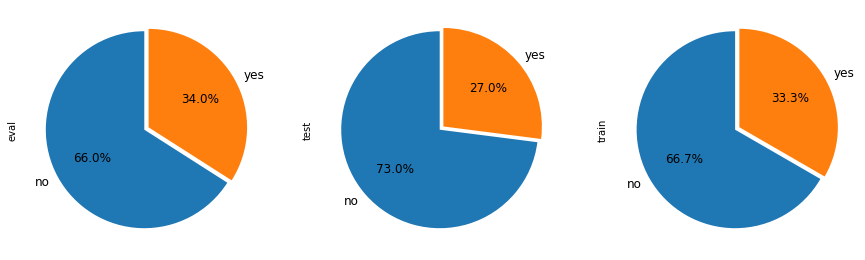

In [20]:
import matplotlib.pyplot as plt

all_df.groupby(['label', 'stage'])['label'].count().unstack('stage').plot(
    kind='pie',
    figsize=(15, 15),
    startangle=90,
    subplots=True,
    autopct='%1.1f%%',
    legend=False,
    explode=(0, 0.05),
    fontsize=12
)

plt.show()

In [22]:
def copy_batch(df):
    batch = [
        (src, src.replace('staging/STUDY_2021/HE', 'processed/STUDY_2021/HE/resized/{}'.format(stage)))
        for src, label, stage in df.values
    ]
    beam.io.gcp.gcsio.GcsIO().copy_batch(batch)

copy_batch(all_df)

---

### Data Augmentation

In [23]:
# training
yes_samples = !gsutil ls gs://ex-vivo-confocal/processed/STUDY_2021/HE/resized/train/YES/*.*
no_samples = !gsutil ls gs://ex-vivo-confocal/processed/STUDY_2021/HE/resized/train/NO/*.*
    
print('Number of YES samples:', len(yes_samples))
print('Number of NO samples:', len(no_samples))

Number of YES samples: 144
Number of NO samples: 288


In [24]:
import math

def calculate_num_samples(df, num_copies):
    num_yes = len(df[df['label'] == 'yes'])
    num_no = len(df[df['label'] == 'no'])
    yes_needed = math.ceil((num_copies - num_yes) / num_yes)
    no_needed = math.ceil((num_copies - num_no) / num_no)
    df['needed'] = df['label'].apply(
        lambda x: \
            yes_needed if x == 'yes' else no_needed
    )
    return df

In [25]:
# training
num_copies = 10000
yes_samples = !gsutil ls gs://ex-vivo-confocal/processed/STUDY_2021/HE/resized/train/YES/*.*
no_samples = !gsutil ls gs://ex-vivo-confocal/processed/STUDY_2021/HE/resized/train/NO/*.*
train_df = calculate_num_samples(
    createDataFrame(yes_samples, no_samples),
    num_copies
)
path = '{}/augmented-train.csv'.format(LOCAL_STAGING_FOLDER)
save_dataset(train_df[['label', 'image', 'needed']], path, header=False)

# validation
num_copies = 2000
yes_samples = !gsutil ls gs://ex-vivo-confocal/processed/STUDY_2021/HE/resized/eval/YES/*.*
no_samples = !gsutil ls gs://ex-vivo-confocal/processed/STUDY_2021/HE/resized/eval/NO/*.*
eval_df = calculate_num_samples(
    createDataFrame(yes_samples, no_samples),
    num_copies
)
path = '{}/augmented-eval.csv'.format(LOCAL_STAGING_FOLDER)
save_dataset(eval_df[['label', 'image', 'needed']], path, header=False)

# testing
num_copies = 2000
yes_samples = !gsutil ls gs://ex-vivo-confocal/processed/STUDY_2021/HE/resized/test/YES/*.*
no_samples = !gsutil ls gs://ex-vivo-confocal/processed/STUDY_2021/HE/resized/test/NO/*.*
test_df = calculate_num_samples(
    createDataFrame(yes_samples, no_samples),
    num_copies
)
path = '{}/augmented-test.csv'.format(LOCAL_STAGING_FOLDER)
save_dataset(test_df[['label', 'image', 'needed']], path, header=False)

Dataframe saved into staging/he/augmented-train.csv
Dataframe saved into staging/he/augmented-eval.csv
Dataframe saved into staging/he/augmented-test.csv


In [26]:
import apache_beam as beam

def synthesise_samples(input_data, output_folder,
                       save_format='jpeg',
                       target_size=(256, 256),
                       job_mame='synthesise_samples',
                       runner='DirectRunner'):
    """
    Create an Apache Beam pipeline to create synthetic copies of pitcture appliying some transformations.
    
    Arguments:
    runner -- two possible values are accepted:
        DirectRunner -- executes the pipeline in the same machine that is running this method. Defaul.
        DataflowRunner -- executes the pipeline on GCP (Google Cloud Platform) using the Dataflow service.
    input_data -- path to a CSV file with the following structure:
        label,path_to_image_file,path_to_copy_file
    output -- path to the output folder
    """
    # Dataflow needs the imports here
    import os, datetime, random, string
    import numpy as np
    
    from PIL import Image
    from io import BytesIO
    from apache_beam.io.gcp import gcsio
    from skimage.transform import resize
    from keras.preprocessing.image import ImageDataGenerator
    
    def load_img(path):
        if path.startswith('gs://'):
            #print(path)
            img = Image.open(gcsio.GcsIO().open(path))
        else:
            img = Image.open(path)
        return np.asarray(img)
        
    def transform(element):
        label, path, needed = element
        hight, width = target_size
        
        img = load_img(path)
        img = resize(img, (hight, width), anti_aliasing=False)
        img = np.expand_dims(img, 0)
        save_to_dir = os.path.join(
                output_folder, label.upper().replace(' ', '_'))
        
        datagen = ImageDataGenerator(
            rotation_range=40,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True)
        
        gen = datagen.flow(img, batch_size=1)

        copies = [ gen.next()[0] for _ in range(int(needed)) ]
        copies.append(img[0])
        return (save_to_dir, copies)
            
    class WriteImage(beam.DoFn):
        def __init__(self, filesystems):
            self.filesystems = filesystems
            
        def process(self, image_tuple):
            directory, copies = image_tuple
            for img_array in copies:
                filename = ''.join(random.choices(string.ascii_letters + string.digits, k=16))
                filename = '{}.{}'.format(filename, save_format)
                path = os.path.join(directory, filename)
                file = BytesIO()
                if save_format == 'jpeg':
                    img = Image.fromarray((img_array * 255).astype(np.uint8)).convert('RGB')
                else:
                    img = Image.fromarray((img_array * 255).astype(np.uint8))
                img.save(file, format=save_format)

                if not os.path.isdir(directory):
                    self.filesystems.FileSystems.mkdirs(directory)

                writer = self.filesystems.FileSystems.create(path)
                writer.write(file.getvalue())
                writer.close()
            
    timestamp = datetime.datetime.now().strftime("%y%m%d-%H%M%S")

    #dictionary of pipeline options
    opts = {
        "staging_location": STAGING_FOLDER,
        "temp_location": "gs://{}/temp".format(BUCKET),
        "job_name": "{}-{}".format(job_mame, timestamp),
        "project": PROJECT,
        "region": REGION,
        "max_num_workers": 8,
        "runner": runner
    }

    #instantiate PipelineOptions object using options dictionary
    options = beam.pipeline.PipelineOptions(flags = [], **opts)
    p = beam.Pipeline(options=options)
    
    (p | 'Read augmented dataset' >> beam.io.ReadFromText(input_data)
       | 'Split augmented data'   >> beam.Map(lambda x: x.split(','))
       | 'Synthesise samples'     >> beam.Map(transform)
       | "Save Image"             >> beam.ParDo(WriteImage(beam.io.filesystems))
    )
    
    p.run()

In [14]:
for stage in ['train', 'eval', 'test']:
    synthesise_samples(
        '{}/augmented-{}.csv'.format(LOCAL_STAGING_FOLDER, stage),
        'gs://ex-vivo-confocal/processed/STUDY_2021/HE/augmented/{}'.format(stage),
        save_format='jpeg',
        target_size=(IMAGE_SIZE, IMAGE_SIZE)
    )
    print('Dataset {} synthesised'.format(stage))

Using TensorFlow backend.


Dataset train synthesised
Dataset eval synthesised
Dataset test synthesised


Download

In [ ]:
%%bash

mkdir -p data/2021_STUDY/HE
gsutil -m cp -r gs://ex-vivo-confocal/processed/STUDY_2021/HE/augmented/* data/2021_STUDY/HE

---